# Temperature REB - Gain Analysis

In this notebook, I analyse the data took on 27th May's night. This dataset is about 800 flat fields with same exposure about same corrected fluxes. The data collection started at 1am right after the dome closure and it finished at 8am after the sunrise. We hope to see temperature variations on the readout board.

Author: Johnny Esteves\
Created on May 30th 2022

In [2]:
from datetime import date

day = date.today()
print(f'Running this code on {day}')

Running this code on 2022-05-30


In [3]:
import sys, os, glob, time
import numpy as np
import pandas as pd
import astropy.io.fits as pf
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

## Searching on Butler

We retrieve all exposure ids of flat fields took at that night.

In [165]:
dayObs=20220527
outname = 'data/flat_field_pairs_auxTel_may2022_single_night_{}.csv'

In [6]:
import lsst.daf.butler as dafButler
butler = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib"])
registry = butler.registry

In [7]:
# find all the flats
flat_ids = []
info_list = []

exposureList = []
for record in butler.registry.queryDimensionRecords("exposure", where="exposure.day_obs=%d"%dayObs):
    exposureList.append([record.id, record])
exposureList.sort(key=lambda x: x[0])
for [id,record] in exposureList:
    info_dict = dict()
    if record.observation_type=='flat':
        info_dict['day'] = int(record.day_obs)
        info_dict['seq_num'] = int(record.seq_num)
        info_dict['exposure_id'] = int(record.id)
        info_dict['exposure_time'] = float(record.exposure_time)
        info_dict['time'] = record.timespan.begin.isot
        flat_ids.append(int(record.id))
        info_list.append(info_dict)

In [8]:
import pandas as pd
df = pd.DataFrame(info_list, index=np.array(flat_ids))
df

,day,seq_num,exposure_id,exposure_time,time
2022052700001,20220527,1,2022052700001,30.0,2022-05-28T04:28:02.321982
2022052700002,20220527,2,2022052700002,1.0,2022-05-28T04:29:49.454010
2022052700003,20220527,3,2022052700003,0.5,2022-05-28T04:33:11.678019
2022052700010,20220527,10,2022052700010,5.0,2022-05-28T04:51:21.448008
2022052700011,20220527,11,2022052700011,10.0,2022-05-28T04:53:33.931015
...,...,...,...,...,...
2022052700797,20220527,797,2022052700797,25.0,2022-05-28T11:58:25.883995
2022052700798,20220527,798,2022052700798,25.0,2022-05-28T11:58:53.440997
2022052700799,20220527,799,2022052700799,25.0,2022-05-28T11:59:21.001016
2022052700800,20220527,800,2022052700800,25.0,2022-05-28T11:59:48.572985


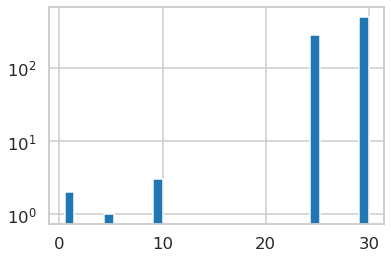

In [9]:
df.exposure_time.hist(bins=31)
plt.yscale('log')

### Retrieving the Corrected Flux

To have a better estimate of the gain, we will use only low flux flat pairs.

In [11]:
from lsst.summit.utils.bestEffort import BestEffortIsr
bestEffort = BestEffortIsr()

def get_flux(day, seq):
    dataId = {'day_obs': day, 'seq_num': seq, 'detector':0}
    try:
        exp = bestEffort.getExposure(dataId)
        mean_flux = np.nanmedian(exp.image.array.flatten())
    except:
        mean_flux = np.nan
    return mean_flux 

Using bestEffor

```
from lsst.summit.utils.bestEffort import BestEffortIsr
bestEffort = BestEffortIsr()
dataId = {'day_obs': 20200312, 'seq_num': 197, 'detector':0}
exp = bestEffort.getExposure(dataId)
```
or

```
import lsst.summit.utils.butlerUtils as butlerUtils
butler = butlerUtils.makeDefaultLatissButler()
dataId = {'day_obs': 20200312, 'seq_num': 197, 'detector':0}
exp = butler.get('quickLookExp', dataId)
```

In [20]:
from time import time
from joblib import Parallel, delayed

if not os.path.isfile(outname.format('flux')):
    t0 = time()
    tables = Parallel(n_jobs=4)(delayed(get_flux)(dayObs, int(df.seq_num.to_numpy()[i])) for i in range(len(df)))
    print(time()-t0)
    
    # flux_array = np.full(len(df), np.nan)
    flux_array = np.array(tables)
    df['Flux'] = flux_array
    df.to_csv(outname.format('flux'))
    print('file saved: %s'%(outname.format('flux')))


1437.8776261806488


In [263]:
# flux_array = np.full(len(df), np.nan)
# Chilean Local Time
df['Time'] = pd.to_datetime(df.time) - pd.Timedelta(hours=4)
df.set_index('Time', inplace=True)

flux_array = np.array(tables)
df['Flux'] = flux_array
df.to_csv(outname.format('flux'))

print('Second file saved: %s'%(outname.format('flux')))


Second file saved: data/flat_field_pairs_auxTel_may2022_single_night_flux.csv


In [483]:
import numpy as np
def get_lims(arr):
    v1,v2,v3 = np.nanpercentile(arr,[25,50,75])
    iqr = (v3-v1)/2
    vlow, vhig = v1-1.5*iqr, v3+1.5*iqr
    return v2, vlow, vhig

In [637]:
if os.path.isfile(outname.format('flux')):
    print('here')
    df = pd.read_csv(outname.format('flux'),index_col=0)
    df0['Time'] = pd.to_datetime(df0.time) - pd.Timedelta(hours=4)
    df0.set_index('Time', inplace=True)

here


In [638]:
df

,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
Time,,,,,,,,,,
2022-05-28 00:28:02.321982,20220527,1,2022052700001,30.0,2022-05-28T04:28:02.321982,155782.6000,NaN,NaN,NaN,NaN
2022-05-28 00:29:49.454010,20220527,2,2022052700002,1.0,2022-05-28T04:29:49.454010,8398.1370,6.832074,0.010585,6.845811,0.010302
2022-05-28 00:33:11.678019,20220527,3,2022052700003,0.5,2022-05-28T04:33:11.678019,4209.1410,6.832074,0.010585,6.845811,0.010302
2022-05-28 00:51:21.448008,20220527,10,2022052700010,5.0,2022-05-28T04:51:21.448008,2528.8080,7.010646,0.005948,7.029533,0.005948
2022-05-28 00:53:33.931015,20220527,11,2022052700011,10.0,2022-05-28T04:53:33.931015,1525.3373,7.010646,0.005948,7.029533,0.005948
...,...,...,...,...,...,...,...,...,...,...
2022-05-28 07:58:25.883995,20220527,797,2022052700797,25.0,2022-05-28T11:58:25.883995,9278.0520,6.696429,0.000000,6.718750,0.000000
2022-05-28 07:58:53.440997,20220527,798,2022052700798,25.0,2022-05-28T11:58:53.440997,9280.7230,6.733631,0.037939,6.763393,0.063135
2022-05-28 07:59:21.001016,20220527,799,2022052700799,25.0,2022-05-28T11:59:21.001016,9284.4710,6.733631,0.037939,6.763393,0.063135


In [639]:
df_all = df.to_numpy().T
exposures = df_all[2]
days = df_all[0]
seq_num = df_all[1].astype(int)
exp_time = df_all[3].astype(float)
flux = df_all[5].astype(float)
log_flux = np.log10(flux)

In [640]:
def get_lims(arr):
    v1,v2,v3 = np.nanpercentile(arr,[25,50,75])
    iqr = (v3-v1)/2
    vlow, vhig = v1-1.5*iqr, v3+1.5*iqr
    return v2, vlow, vhig

In [641]:
log_fmean, log_flow, log_fhig = get_lims(log_flux)
print(f'Lower, upper bounds: {10**log_flow}, {10**log_fhig}')
noutliers = (log_flux>log_flow) & (log_flux<log_fhig)

Lower, upper bounds: 8132.725027051347, 12935.629927271613


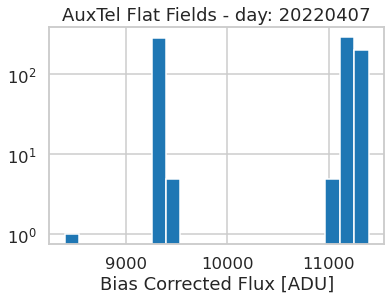

In [642]:
# plt.hist(flux,bins=21)
plt.hist(flux[noutliers],bins=21)
# plt.axvline(fmean,ls='--',lw=3,label='Mean Flux')
plt.xlabel('Bias Corrected Flux [ADU]')
plt.title(f'AuxTel Flat Fields - day: {day}')
# plt.xscale('log')
plt.yscale('log')

In [643]:
good = (flux<13e3)&(flux>5000)
df0 = df.iloc[good].copy()

In [644]:
# from astropy.time import Time, TimeDelta
# Chilean Local Time
df0['Time'] = pd.to_datetime(df0.time) - pd.Timedelta(hours=4)
df0.set_index('Time', inplace=True)

In [645]:
# df0.resample("15Min").mean().Flux.plot(kind='bar', rot=0, ax=axs)

Text(0, 0.5, 'Corrected Flux [ADU]')

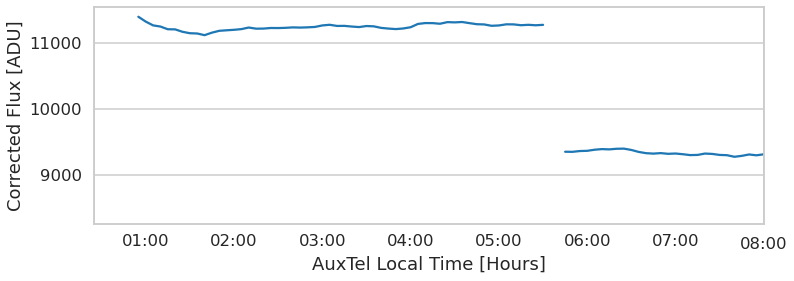

In [646]:
fig, axs = plt.subplots(figsize=(12, 4))
df0.resample("5Min").mean().Flux.plot(rot=0, ax=axs)
plt.xlabel("AuxTel Local Time [Hours]")
plt.ylabel("Corrected Flux [ADU]")

## Query Temperature

In this section, we query the temperature for each exposure

In [647]:
from lsst_efd_client import EfdClient, resample
from astropy.time import Time, TimeDelta

efd_client = EfdClient('ldf_stable_efd')


In [648]:
temp_data = np.full(len(df), np.nan, 
                    dtype=[('t1', float), 
                          ('t1_err', float),
                          ('t2', float), 
                          ('t2_err', float)])

In [649]:
times = df.time.to_numpy()

In [499]:
# times

In [650]:
for ii in np.arange(1,len(df),2):
    exposure = exposures[ii]
    time1 = Time(times[ii], format='isot', scale='tai')
    time2 = Time(times[ii+1], format='isot', scale='tai')
    
    if exposure < 20211013:
        # EFD was switched to UTC on 20211013.  This compensates for that.
        tai_offset = 37.0
    else:
        tai_offset = 0.0
    t1 = time1 - TimeDelta(-1., format='sec', scale='tai')
    t2 = time2 + TimeDelta(+1., format='sec', scale='tai')
    
    res1 = await efd_client.select_time_series("lsst.sal.ATCamera.focal_plane_Reb", 
                                               ["aspicl_Temp00","aspicu_Temp00"], 
                                               t1.utc - TimeDelta(tai_offset, format='sec'), 
                                               t2.utc - TimeDelta(tai_offset, format='sec'))
    # print(res1)
    if len(res1)>0:
        t1 = np.mean(res1['aspicl_Temp00'])
        t1_err = np.std(res1['aspicl_Temp00'])
        t2 = np.mean(res1['aspicu_Temp00'])
        t2_err = np.std(res1['aspicu_Temp00'])

        temp_data[ii] = (t1, t1_err, t2, t2_err)
        temp_data[ii+1] = (t1, t1_err, t2, t2_err)


In [651]:
df['Temp1'] = temp_data['t1']
df['TempErr1'] = temp_data['t1_err']
df['Temp2'] = temp_data['t2']
df['TempErr2'] = temp_data['t2_err']
df.to_csv(outname.format('flux_temp'))
print('First file saved: %s'%(outname.format('flux_temp')))


First file saved: data/flat_field_pairs_auxTel_may2022_single_night_flux_temp.csv


In [652]:
# with pd.option_context('display.max_rows', None,):
print(df[['day','exposure_time','Temp1']])

                                 day  exposure_time     Temp1
Time                                                         
2022-05-28 00:28:02.321982  20220527           30.0       NaN
2022-05-28 00:29:49.454010  20220527            1.0  6.830357
2022-05-28 00:33:11.678019  20220527            0.5  6.830357
2022-05-28 00:51:21.448008  20220527            5.0  7.010646
2022-05-28 00:53:33.931015  20220527           10.0  7.010646
...                              ...            ...       ...
2022-05-28 07:58:25.883995  20220527           25.0  6.696429
2022-05-28 07:58:53.440997  20220527           25.0  6.711310
2022-05-28 07:59:21.001016  20220527           25.0  6.711310
2022-05-28 07:59:48.572985  20220527           25.0  6.718750
2022-05-28 08:00:16.137993  20220527           25.0  6.718750

[795 rows x 3 columns]


In [653]:
nan = np.isnan(temp_data['t1'])
nnan = ~nan
print(np.count_nonzero(nnan))
df.iloc[nnan]

794


,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
Time,,,,,,,,,,
2022-05-28 00:29:49.454010,20220527,2,2022052700002,1.0,2022-05-28T04:29:49.454010,8398.1370,6.830357,0.010723,6.844952,0.010619
2022-05-28 00:33:11.678019,20220527,3,2022052700003,0.5,2022-05-28T04:33:11.678019,4209.1410,6.830357,0.010723,6.844952,0.010619
2022-05-28 00:51:21.448008,20220527,10,2022052700010,5.0,2022-05-28T04:51:21.448008,2528.8080,7.010646,0.005948,7.029533,0.005948
2022-05-28 00:53:33.931015,20220527,11,2022052700011,10.0,2022-05-28T04:53:33.931015,1525.3373,7.010646,0.005948,7.029533,0.005948
2022-05-28 00:55:06.389013,20220527,12,2022052700012,10.0,2022-05-28T04:55:06.389013,4491.4194,7.040816,0.011046,7.050382,0.007811
...,...,...,...,...,...,...,...,...,...,...
2022-05-28 07:58:25.883995,20220527,797,2022052700797,25.0,2022-05-28T11:58:25.883995,9278.0520,6.696429,0.000000,6.711310,0.010522
2022-05-28 07:58:53.440997,20220527,798,2022052700798,25.0,2022-05-28T11:58:53.440997,9280.7230,6.711310,0.010522,6.718750,0.000000
2022-05-28 07:59:21.001016,20220527,799,2022052700799,25.0,2022-05-28T11:59:21.001016,9284.4710,6.711310,0.010522,6.718750,0.000000


In [654]:
print('Flat Fields Pairs')
print(f'in all flux range: {len(df)/2}')
print(f'between 5k and 10k ADU: {np.count_nonzero(good)/2}')
print(f'with temperature: {np.count_nonzero(nnan)/2}')

Flat Fields Pairs
in all flux range: 397.5
between 5k and 10k ADU: 394.5
with temperature: 397.0


In [655]:
df1 = df.iloc[good&nnan].copy()

In [656]:
df1

,day,seq_num,exposure_id,exposure_time,time,Flux,Temp1,TempErr1,Temp2,TempErr2
Time,,,,,,,,,,
2022-05-28 00:29:49.454010,20220527,2,2022052700002,1.0,2022-05-28T04:29:49.454010,8398.137,6.830357,0.010723,6.844952,0.010619
2022-05-28 00:57:11.851982,20220527,14,2022052700014,30.0,2022-05-28T04:57:11.851982,11396.874,7.065319,0.011145,7.071194,0.009100
2022-05-28 00:59:59.994019,20220527,15,2022052700015,30.0,2022-05-28T04:59:59.994019,11386.195,7.065319,0.011145,7.071194,0.009100
2022-05-28 01:00:32.555017,20220527,16,2022052700016,30.0,2022-05-28T05:00:32.555017,11382.630,7.083333,0.010522,7.120536,0.031567
2022-05-28 01:01:05.115009,20220527,17,2022052700017,30.0,2022-05-28T05:01:05.115009,11388.292,7.083333,0.010522,7.120536,0.031567
...,...,...,...,...,...,...,...,...,...,...
2022-05-28 07:58:25.883995,20220527,797,2022052700797,25.0,2022-05-28T11:58:25.883995,9278.052,6.696429,0.000000,6.711310,0.010522
2022-05-28 07:58:53.440997,20220527,798,2022052700798,25.0,2022-05-28T11:58:53.440997,9280.723,6.711310,0.010522,6.718750,0.000000
2022-05-28 07:59:21.001016,20220527,799,2022052700799,25.0,2022-05-28T11:59:21.001016,9284.471,6.711310,0.010522,6.718750,0.000000


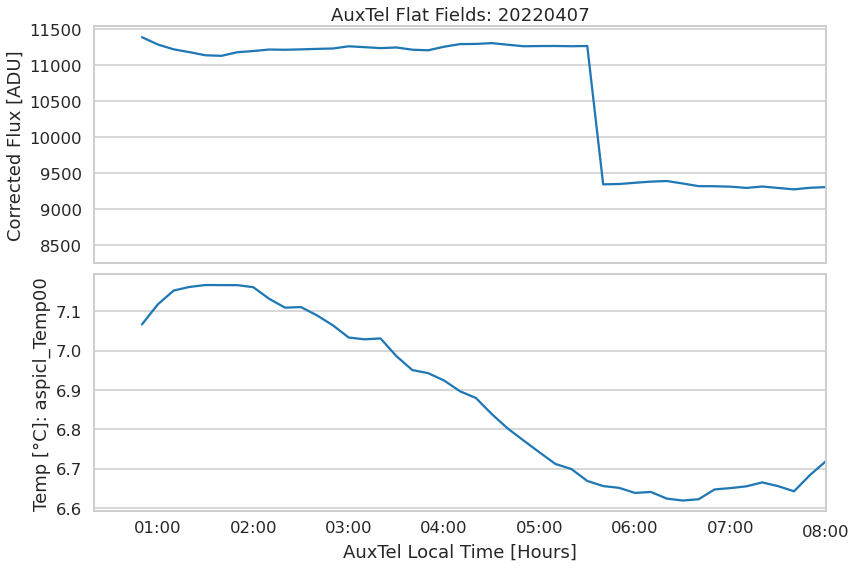

In [657]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex='all')
fig.subplots_adjust(hspace=0.01)
df0.resample("10Min").mean().Flux.plot(rot=0, ax=axs[0])
axs[0].set_xlabel("AuxTel Local Time [Hours]")
axs[0].set_ylabel("Corrected Flux [ADU]")

df0.resample("10Min").mean().Temp1.plot(rot=0, ax=axs[1])
axs[1].set_xlabel("AuxTel Local Time [Hours]")
axs[1].set_ylabel("Temp [°C]: aspicl_Temp00")

axs[0].set_title(f'AuxTel Flat Fields: {day}')
fig.tight_layout()
fig.savefig(f'./plots/timeseries_flux_temp_{day}.pdf',dpi=100)

In [508]:
# outname = 'flat_field_pairs_auxTel_2022.csv'
# df.iloc[good_indices].to_csv(outname)

## Prepare to run pipestack

Synthax:
```
pipetask run -j 32 -d "detector IN (0) AND instrument='LATISS' AND \
     exposure IN (2022052700014..2022052700801) AND exposure.observation_type='flat'" \
     -b /repo/main \
     -c isr:doFlat=False \
     -c ptcExtract:matchByExposureId=True \
     -i LATISS/raw/all,LATISS/calib,LATISS/calib \
     -o u/jesteves/latiss/ptc_20220527 \
     -p $CP_PIPE_DIR/pipelines/Latiss/cpPtc.yaml#gainFromFlatPairs \
     --register-dataset-types
```

In [658]:
print(f"Collection: u/jesteves/latiss/ptc_tREB_rerun_{day}")
butleri = dafButler.Butler("/repo/main", collections=["LATISS/raw/all","LATISS/calib", 
                                                      f"u/jesteves/latiss/ptc_20220527"])
registry = butleri.registry

Collection: u/jesteves/latiss/ptc_tREB_rerun_20220407


In [659]:
for dtype in registry.queryDatasetTypes():
    try:
        datasetRefs = list(registry.queryDatasets(datasetType=dtype,collections=[f"u/jesteves/latiss/ptc_20220527"]))
        if len(datasetRefs)>0:
            print(len(datasetRefs), dtype )
    except:
        #print("Error", dtype )
        i=0

38124 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
1 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
1 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
6 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
1 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
1 DatasetType('packages', {}, Packages)
788 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
1 DatasetType('isr_config', {}, Config)
788 DatasetType('cpPtcProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
788 DatasetType('cpCovariances', {band, instrument, detector, physical_filter, exposure}, PhotonTransferCurveDataset)
1 DatasetType('ptcExtract_metadata', {instrument, detector}, PropertySet)
1 DatasetType('ptcExtract_config', {}, C

In [660]:
dataset_refs = list(registry.queryDatasets('cpCovariances', collections=[f"u/jesteves/latiss/ptc_20220527"]))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['exposure'])
exposures = [di.dataId['exposure'] for di in dataset_refs]
exposures_all = df.exposure_id.to_numpy().astype(int)
print(len(dataset_refs))


788


In [661]:
# # to debug
# ptcDataset = butleri.get('cpCovariances', exposure=exposures[0], detector=0, instrument='LATISS')
# gain_data = ptcDataset.gain
# gain_err_data = ptcDataset.gainErr

In [682]:
gain1 = np.full(len(df), np.nan, dtype=[('gain', float)])
gain2 = np.full(len(df), np.nan, dtype=[('gain_err', float)])

In [683]:
for i in range(len(exposures)):
    #print(exposures[i])
    ix, = np.where(exposures_all==exposures[i])[0]
    run_name = str(exposures[i])

    ptcDataset = butleri.get('cpCovariances', exposure=exposures[i], detector=0, instrument='LATISS')
    gain_amps = ptcDataset.gain
    gain_amps_err = ptcDataset.gainErr
    amps = gain_amps_err.keys()
    gains = []
    gain_err = []
    amp_nums = []
    for ii, amp in enumerate(amps):
        gains.append(gain_amps[amp])
        gain_err.append(gain_amps_err[amp])
        amp_nums.append(ii)
    if np.mean(gains)!=0:
        mean_gain = np.nanmedian(np.where(np.array(gains)==0,np.nan,gains))
        mean_gain_err = np.nanmedian(np.sqrt(np.array(gain_err)**2 + np.nanstd(gains)**2))
        #gain_data[ix] = (mean_gain, mean_gain_err)
        gain1[ix] = mean_gain
        gain2[ix] = mean_gain_err

In [684]:
# filling out the pairs
even = np.arange(8, len(df), 2)
odds = np.arange(7, len(df), 2)

gain1[odds] = np.where(np.isnan(gain1['gain'][odds]),gain1['gain'][even],gain1['gain'][odds])
gain1[even] = np.where(np.isnan(gain1['gain'][even]),gain1['gain'][odds],gain1['gain'][even])

gain2[odds] = np.where(np.isnan(gain2['gain_err'][odds]),gain2['gain_err'][even],gain2['gain_err'][odds])
gain2[even] = np.where(np.isnan(gain2['gain_err'][even]),gain2['gain_err'][odds],gain2['gain_err'][even])


In [685]:
gmean, glow, ghig = get_lims(gain2['gain_err'])
gain2['gain_err'] = np.where((gain2['gain_err']<ghig)&(gain2['gain_err']>glow), gain2['gain_err'], np.nanmedian(gain2['gain_err']))

In [687]:
df['Gain'] = gain1['gain']
df['GainErr'] = gain2['gain_err']
df.to_csv(outname.format('flux_temp_gain'))
print('First file saved: %s'%(outname.format('flux_temp_gain')))


First file saved: data/flat_field_pairs_auxTel_may2022_single_night_flux_temp_gain.csv


In [688]:
gmean, glow, ghig = get_lims(gain1['gain'])
print(f'Lower, upper bounds: {glow}, {ghig}')
g_outliers = (0.9<gain_data['gain']) & (1.1>gain1['gain'])

Lower, upper bounds: 1.0473156469550824, 1.0664083167784693


In [689]:
df0 = df.iloc[good&nnan&g_outliers].copy()
df0['Time'] = pd.to_datetime(df0.time) - pd.Timedelta(hours=4)
df0.set_index('Time', inplace=True)

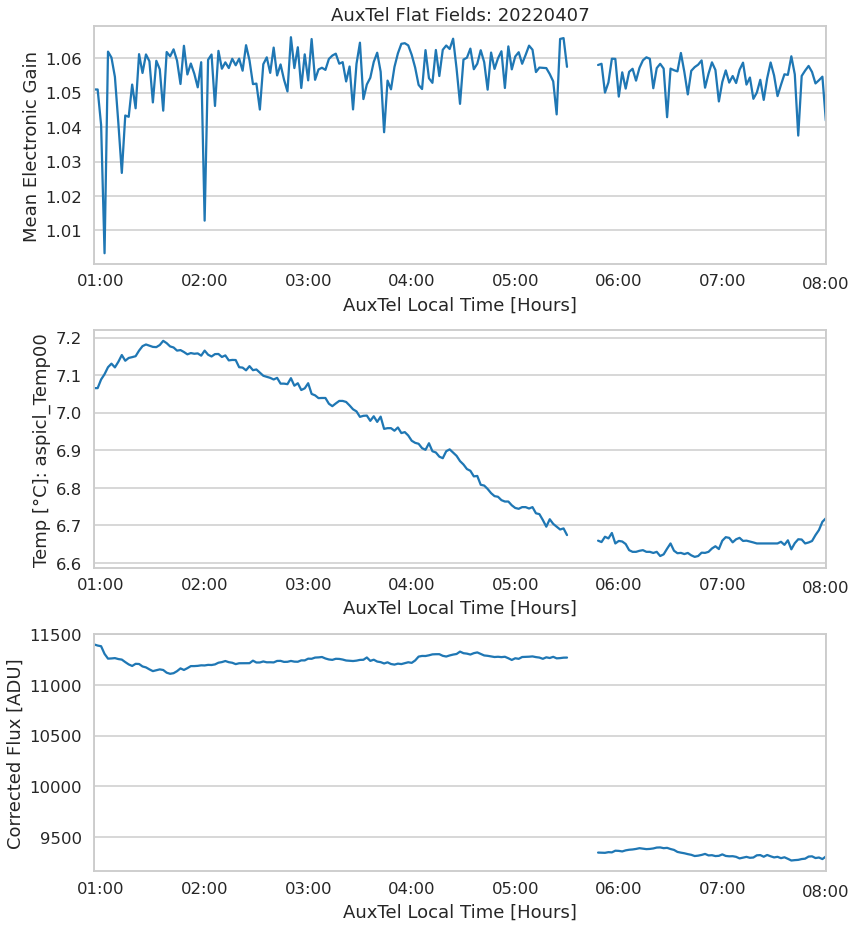

In [743]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12+1))#, sharex='all')
fig.subplots_adjust(hspace=0.1)
df0.resample("2Min").mean().Flux.plot(rot=0, ax=axs[2])
axs[2].set_xlabel("AuxTel Local Time [Hours]")
axs[2].set_ylabel("Corrected Flux [ADU]")

df0.resample("2Min").mean().Temp1.plot(rot=0, ax=axs[1])
axs[1].set_xlabel("AuxTel Local Time [Hours]")
axs[1].set_ylabel("Temp [°C]: aspicl_Temp00")

df0.resample("2Min").mean().Gain.plot(rot=0, ax=axs[0])
axs[0].set_xlabel("AuxTel Local Time [Hours]")
axs[0].set_ylabel("Mean Electronic Gain")

axs[0].set_title(f'AuxTel Flat Fields: {day}')
fig.tight_layout()
fig.savefig(f'./plots/timeseries_flux_temp_gain_{day}.pdf',dpi=100)

In [691]:
vecs = df0.to_numpy().T

gain = vecs[-2].astype(float)
gain_err = vecs[-1].astype(float)
flux = vecs[5].astype(float)
temp = vecs[6].astype(float)

In [692]:
hours = df0.index.hour.to_numpy()
# hours

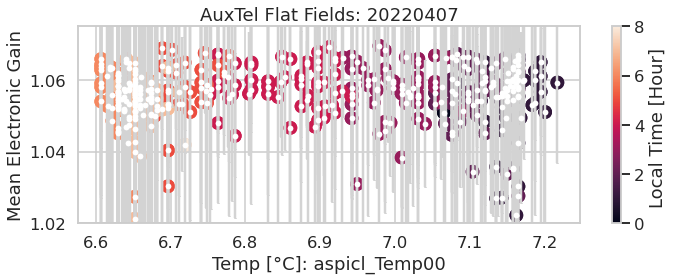

In [693]:
plt.figure(figsize=(10,4))
plt.scatter(temp, gain, c=hours, label=day, s=150)
plt.errorbar(temp, gain, yerr=gain_err,
         fmt='.w',capsize=1,ecolor='lightgray')
plt.ylim(1.02,1.075)

plt.colorbar().set_label('Local Time [Hour] ')
plt.ylabel("Mean Electronic Gain")
plt.xlabel("Temp [°C]: aspicl_Temp00")
plt.title(f'AuxTel Flat Fields: {day}')
plt.tight_layout()
plt.savefig(f'./plots/temp_gain_May27.pdf',dpi=100)

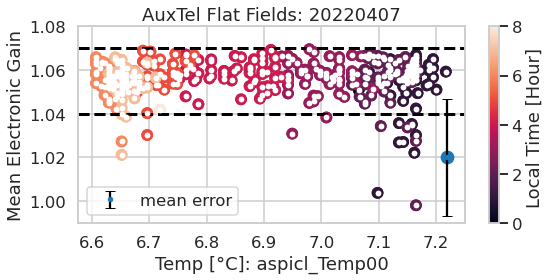

In [744]:
plt.figure(figsize=(8,4))
plt.scatter(7.22, 1.02, s=150)
plt.errorbar(7.22, 1.02, yerr=np.mean(gain_err)/2.,
         fmt='.',color='tab:blue',capsize=5,ecolor='k', label='mean error')
plt.legend(loc=3)
plt.scatter(temp, gain, c=hours, label=day, s=105)
plt.errorbar(temp, gain, 
         fmt='.w',capsize=1,ecolor='lightgray')

plt.axhline(1.07, color='k', lw=3, ls='--')
plt.axhline(1.04, color='k', lw=3, ls='--')
plt.ylim(0.99,1.08)

plt.colorbar().set_label('Local Time [Hour] ')
plt.ylabel("Mean Electronic Gain")
plt.xlabel("Temp [°C]: aspicl_Temp00")
plt.title(f'AuxTel Flat Fields: {day}')
plt.tight_layout()
plt.savefig(f'./plots/temp_gain_May27.pdf',dpi=100)

In [636]:
print(np.mean(gain), np.std(gain), np.mean(gain_err))

1.0556024563324162 0.009507234496751038 0.03993717261563971


(array([  2.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,   2.,   2.,
         10.,   8.,  10.,  12.,  34.,  76., 208., 230., 118.,  70.]),
 array([0.97780626, 0.98217561, 0.98654497, 0.99091433, 0.99528368,
        0.99965304, 1.00402239, 1.00839175, 1.01276111, 1.01713046,
        1.02149982, 1.02586918, 1.03023853, 1.03460789, 1.03897724,
        1.0433466 , 1.04771596, 1.05208531, 1.05645467, 1.06082403,
        1.06519338, 1.06956274]),
 <BarContainer object of 21 artists>)

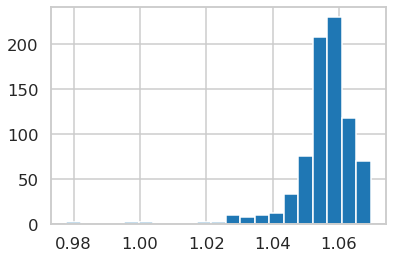

In [630]:
plt.hist(gain,bins=21)